In [280]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from scipy.stats import zscore
#add other imports as needed

In [281]:
import os

In [282]:
import platform

# Set file location based on platform. 
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/TReND2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2024/"

In [283]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')

boc = BrainObservatoryCache(manifest_file=manifest_file)

In [284]:
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

manifest_path = os.path.join(data_root,'allen-brain-observatory/visual-coding-neuropixels/ecephys-cache/manifest.json') 

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [285]:
areas = boc.get_all_targeted_structures()
areas

['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']

In [286]:
cre_lines = boc.get_all_cre_lines()
cre_lines

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']

In [287]:
imaging_depths = boc.get_all_imaging_depths()
imaging_depths

[175,
 185,
 195,
 200,
 205,
 225,
 250,
 265,
 275,
 276,
 285,
 300,
 320,
 325,
 335,
 350,
 365,
 375,
 390,
 400,
 550,
 570,
 625]

In [288]:
visual_area = [areas[0]]
cre_line = [cre_lines[1]]
imaging_depth = imaging_depths[:7]

In [289]:
#create an empty dataframe with colums as areas and index as cre_lines
df = pd.DataFrame(columns=areas,index=cre_line)

#populate the dataframe with the number of experiment containers for each combination
for area in areas:
    exps = boc.get_experiment_containers(targeted_structures=[area],cre_lines=cre_line,imaging_depths=imaging_depth)
    df[area].loc[cre_line] = len(exps)

df['Total'] = df.sum(axis=1).astype(int)

#look at dataframe
print(df)

              VISal VISam VISl VISp VISpm VISrl  Total
Emx1-IRES-Cre     2     1    5    3     2     4     17


In [290]:
exps = boc.get_experiment_containers(targeted_structures=visual_area,cre_lines=cre_line,imaging_depths=imaging_depth)
pd.DataFrame(exps)

,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
0,560753319,175,VISal,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),280639,Emx1-IRES-Cre;Camk2a-tTA;Ai93-280639,[],False
1,560876149,175,VISal,Emx1-IRES-Cre,Ai93(TITL-GCaMP6f),280643,Emx1-IRES-Cre;Camk2a-tTA;Ai93-280643,[],False


In [291]:
experiment_container_ids = [exps[0]['id']]

In [292]:
sessions = boc.get_ophys_experiments(experiment_container_ids=experiment_container_ids, stimuli=['natural_scenes'])
sessions

[{'id': 560802931,
  'imaging_depth': 175,
  'targeted_structure': 'VISal',
  'cre_line': 'Emx1-IRES-Cre',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 81,
  'experiment_container_id': 560753319,
  'session_type': 'three_session_B',
  'donor_name': '280639',
  'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93-280639',
  'fail_eye_tracking': True}]

In [293]:
session_id = sessions[0]['id']
session_id

560802931

In [294]:
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

In [295]:
stim_table = data_set.get_stimulus_table('natural_scenes')
stim_table.start

0       16128
1       16136
2       16144
3       16151
4       16159
        ...  
5945    96238
5946    96245
5947    96253
5948    96260
5949    96268
Name: start, Length: 5950, dtype: int64

In [296]:
(stim_table.end-stim_table.start != 7).sum()

225

In [297]:
stim_start = stim_table.start.min()
stim_end = stim_table.end.max()+1

In [298]:
events = boc.get_ophys_experiment_events(ophys_experiment_id=session_id)[:,stim_start:stim_end]
events.shape

(206, 80148)

In [299]:
stim_table.end = stim_table.end - stim_start
stim_table.start = stim_table.start - stim_start

In [300]:
stim_table


,frame,start,end
0,51,0,7
1,79,8,15
2,18,16,23
3,96,23,30
4,17,31,38
...,...,...,...
5945,81,80110,80117
5946,72,80117,80124
5947,96,80125,80132
5948,24,80132,80139


In [301]:
stim_epoch = data_set.get_stimulus_epoch_table()
stim_epoch

,stimulus,start,end
0,static_gratings,736,15223
1,natural_scenes,16128,30605
2,spontaneous,30755,39652
3,natural_scenes,39653,54129
4,static_gratings,55034,69510
5,natural_movie_one,70415,79463
6,natural_scenes,80368,96275
7,static_gratings,97559,113842


Text(0.5, 0, 'Aquisition frames')

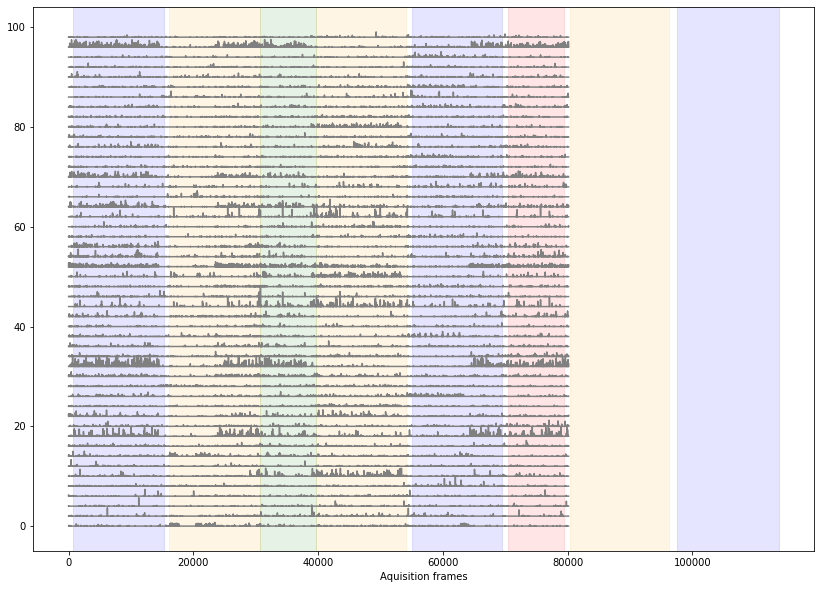

In [302]:
fig = plt.figure(figsize=(14,10))
for i in range(50):
    plt.plot(events[i,:]+(i*2), color='gray')

    
#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)
        
plt.xlabel("Aquisition frames")

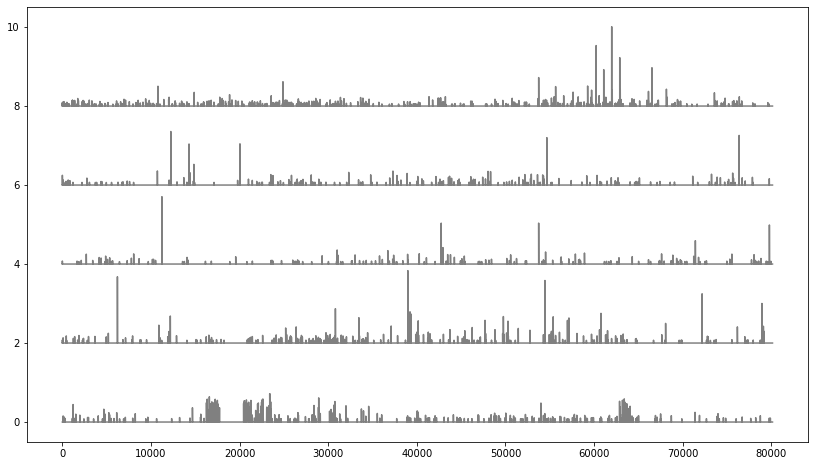

In [303]:
fig = plt.figure(figsize=(14,8))
for i in range(5):
    plt.plot(events[i,:]+(i*2), color='gray')

In [304]:
natural_scene_table = data_set.get_stimulus_table('natural_scenes')

In [305]:
natural_scene_table.head()

,frame,start,end
0,51,16128,16135
1,79,16136,16143
2,18,16144,16151
3,96,16151,16158
4,17,16159,16166


In [306]:
natural_scene_table.frame.unique().shape[0]

119

In [307]:
no_of_scenes = natural_scene_table.frame.unique().shape[0]

In [308]:
natural_scene_table.end - natural_scene_table.start

0       7
1       7
2       7
3       7
4       7
       ..
5945    7
5946    7
5947    7
5948    7
5949    7
Length: 5950, dtype: int64

In [309]:
natural_scene_template = data_set.get_stimulus_template('natural_scenes')

In [310]:
natural_scene_template.shape

(118, 918, 1174)

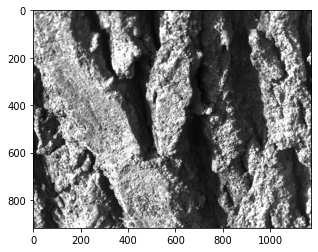

In [311]:
scene_number = 76
plt.imshow(natural_scene_template[scene_number,:,:], cmap='gray')

In [312]:
events_thresh = np.where(events>0.2, 1, 0)
events_thresh.shape

(206, 80148)

In [313]:
averaging_indices = stim_table.end.to_numpy()
averaging_indices.shape

(5950,)

In [314]:
cum_events = events_thresh.cumsum(axis=1)[:,averaging_indices]
trial_responses = np.c_[cum_events[:,1] ,np.diff(cum_events, axis=1)]
trial_responses

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [315]:
trial_responses.sum(axis=0)

array([25,  4,  8, ...,  0, 12,  1])

In [316]:
trial_responses.sum()

40040

In [317]:
trial_responses_df = pd.DataFrame(trial_responses.mean(axis=0))
print(trial_responses_df.shape)
# Calculate the Z-score for each data point
z_scores = trial_responses_df.apply(zscore)
# Identify rows with any outlier (Z-score > 3 or Z-score < -3)
outliers = (trial_responses_df[(z_scores > 3) | (z_scores < -3)].to_numpy() > 0).nonzero()[0]
outliers

(5950, 1)


array([1920, 3840])

In [318]:
trial_responses = np.delete(trial_responses, outliers, axis=1)
trial_responses.shape

(206, 5948)

Text(0, 0.5, 'trial_responses')

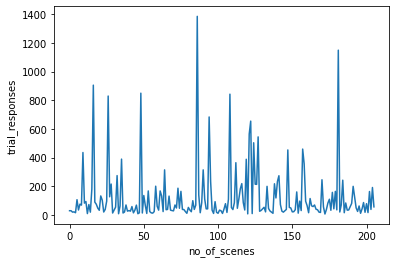

In [320]:
plt.plot(trial_responses.sum(axis=1))
plt.xlabel ('no_of_scenes')
plt.ylabel ('trial_responses')

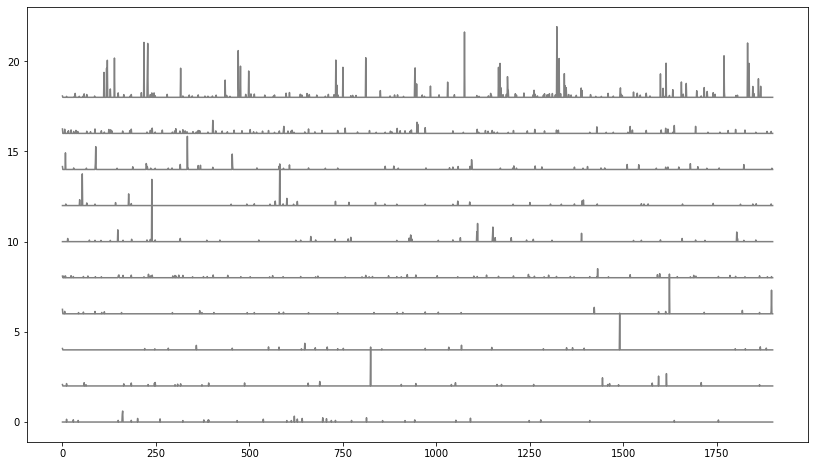

In [183]:
fig = plt.figure(figsize=(14,8))
for i in range(10):
    plt.plot(trial_responses[i,:]+(i*2), color='gray')

Text(0.5, 0, 'Aquisition frames')

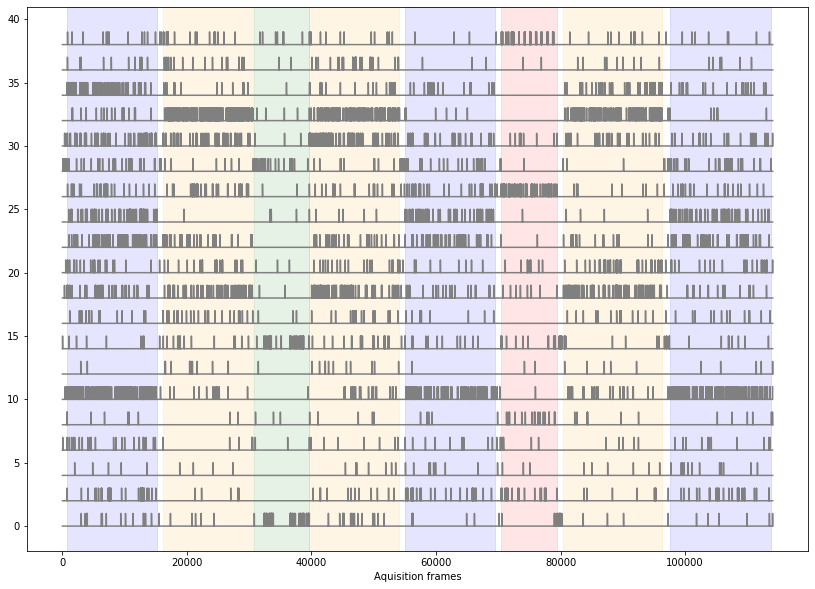

In [120]:
fig = plt.figure(figsize=(14,10))
for i in range(20):
    plt.plot(events_thresh[i,:]+(i*2), color='gray')

    
#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)
        
plt.xlabel("Aquisition frames")

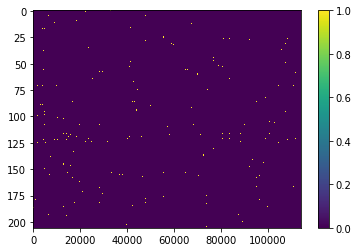

In [127]:
cell_mat = events_thresh

plt.imshow(cell_mat,vmax=1,interpolation='nearest',aspect='auto')

plt.colorbar()

In [126]:
plt.plot(np.sum(cell_mat,dim=0))

TypeError: _sum_dispatcher() got an unexpected keyword argument 'dim'